In [ ]:
# Install required libraries
# The -q flag keeps the output brief.
# yt-dlp downloads video metadata and captions.
# pandas handles tabular data.
# matplotlib draws plots.
# webvtt-py parses caption files.
# youtube-comment-downloader and google-api-python-client are used for fetching comments.
!pip install -q yt-dlp pandas matplotlib webvtt-py youtube-comment-downloader google-api-python-client

In [ ]:
import sys, subprocess, re, string
from datetime import datetime

import webvtt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Fetch comments using the YouTube Data API
from googleapiclient.discovery import build

In [ ]:
# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=WXsD0ZgxjRw'

In [ ]:
# Download captions
subprocess.run([
    'yt-dlp',
    '--skip-download',            # do not download the video itself
    '--write-auto-sub',           # fetch auto-generated captions
    '--sub-lang', 'en',           # limit to English
    '--convert-subs', 'vtt',      # convert subtitles to VTT format
    '-o', 'captions.%(ext)s',     # output filename pattern (captions.en.vtt)
    video_url
], check=True)

CompletedProcess(args=['yt-dlp', '--skip-download', '--write-auto-sub', '--sub-lang', 'en', '--convert-subs', 'vtt', '-o', 'captions.%(ext)s', 'https://www.youtube.com/watch?v=WXsD0ZgxjRw'], returncode=0)

In [ ]:
# Load captions from VTT file
caption_texts = []  # caption text list
caption_times = []  # start times of captions list

# Read each caption from the VTT file
for caption in webvtt.read('captions.en.vtt'):
    text = caption.text.strip()
    if text:
        caption_texts.append(text)
        # Convert the start timestamp (HH:MM:SS.mmm) to seconds
        h, m, s = caption.start.split(':')
        seconds = int(h) * 3600 + int(m) * 60 + float(s)
        caption_times.append(seconds)

print(f'Loaded {len(caption_texts)} captions.')

Loaded 9934 captions.


In [ ]:
# Fetch comments using the YouTube Data API.
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("YOUTUBE_API_KEY")
assert api_key, "Set YOUTUBE_API_KEY in a .env file before running."

video_id = video_url.split('v=')[-1]
youtube = build('youtube', 'v3', developerKey=api_key)

comments_api = []
next_page_token = None

while True:
    response = youtube.commentThreads().list(
        part='snippet,replies',
        videoId=video_id,
        pageToken=next_page_token,
        order='time',          # newest to oldest
        maxResults=100
    ).execute()

    for item in response['items']:
        # Top-level comment
        top_snippet = item['snippet']['topLevelComment']['snippet']
        comments_api.append({'text': top_snippet['textDisplay'],
                             'like_count': top_snippet.get('likeCount', 0),
                             'timestamp': top_snippet['publishedAt']})
        # Replies (if any)
        if 'replies' in item:
            for reply in item['replies']['comments']:
                rs = reply['snippet']
                comments_api.append({'text': rs['textDisplay'],
                                     'like_count': rs.get('likeCount', 0),
                                     'timestamp': rs['publishedAt']})

    next_page_token = response.get('nextPageToken')
    if not next_page_token:
        break

print(f'Fetched {len(comments_api)} total comments (including replies) via the API.')

Fetched 980 total comments (including replies) via the API.


In [ ]:
# Clean comment and remove duplicate comments

# Text cleaning function
def clean_text(text):
    '''Remove newlines, punctuation and non-ASCII characters from a string,
    convert to lowercase and strip extra spaces.'''
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis and other non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.lower()
    text = text.strip()
    return text
for c in comments_api:
    c['clean_text'] = clean_text(c['text'])

# Remove duplicate comments based on the cleaned text
unique_comments = {}
for c in comments_api:
    key = c['clean_text']
    if key not in unique_comments:
        unique_comments[key] = c

unique_comments_list = list(unique_comments.values())
print(f'{len(unique_comments_list)} unique comments after cleaning.')

# Compute a list of cleaned comment texts for later analysis
clean_comments = [c['clean_text'] for c in unique_comments_list]

929 unique comments after cleaning.


In [ ]:
# Prepare cleaned captions for analysis
clean_captions = [clean_text(t) for t in caption_texts]
print(f'Prepared {len(clean_captions)} cleaned captions.')

Prepared 9934 cleaned captions.


In [ ]:
# Sort comments by like count in descending order and select the top 200
selected_comments = sorted(unique_comments_list,
                           key=lambda x: x['like_count'],
                           reverse=True)[:200]
print(f'Selected top {len(selected_comments)} comments by like count.')

# Save raw comments (all fetched comments)
with open('all_comments.txt', 'w', encoding='utf-8') as f:
    for c in comments_api:
        f.write(c['text'] + '\n')

# Save unique cleaned comments
with open('unique_comments.txt', 'w', encoding='utf-8') as f:
    for c in unique_comments_list:
        f.write(c['clean_text'] + '\n')

# Save selected comments to CSV and TXT
if selected_comments:
    df_selected = pd.DataFrame(selected_comments)
    df_selected.to_csv('selected_comments.csv', index=False)
    df_selected['text'].to_csv('selected_comments.txt', index=False, header=False)
    print('Saved all_comments.txt, unique_comments.txt, selected_comments.csv and selected_comments.txt.')
else:
    print('No comments selected.')

Selected top 200 comments by like count.
Saved all_comments.txt, unique_comments.txt, selected_comments.csv and selected_comments.txt.


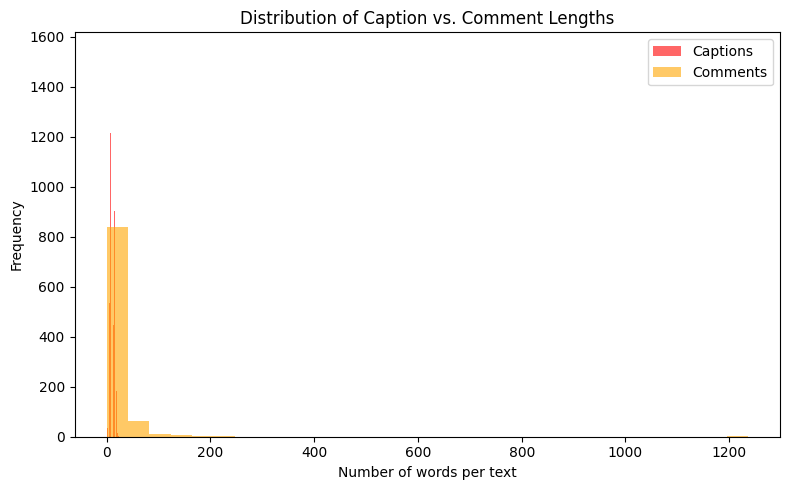

In [ ]:
# Histogrsm: Caption vs. Comment lengths

# Calculate lengths (number of words per text)
caption_lengths = [len(t.split()) for t in caption_texts]
comment_lengths = [len(t.split()) for t in clean_comments]

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(caption_lengths, bins=30, alpha=0.6, color='red', label='Captions')
plt.hist(comment_lengths, bins=30, alpha=0.6, color='orange', label='Comments')
plt.xlabel('Number of words per text')
plt.ylabel('Frequency')
plt.title('Distribution of Caption vs. Comment Lengths')
plt.legend()
plt.tight_layout()
plt.savefig('caption_vs_comment_lengths.png')
plt.show()


We can easily observe that most of the captions and comments are short. However, comments have a wider range despite a few extend to hundreds of words. On the other hand, captions remain tightly clustered. This suggests that captions are kept concise for readability, whereas comments vary widely depending on how the audiences feel.

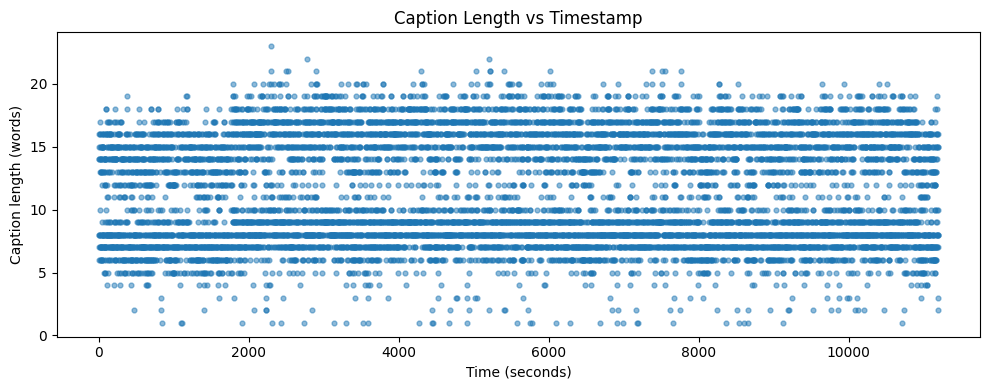

In [ ]:
# Scatter Plot: Caption length vs Timestamp
caption_lengths = [len(t.split()) for t in caption_texts]

plt.figure(figsize=(10, 4))
plt.scatter(caption_times, caption_lengths, alpha=0.5, s=12)
plt.xlabel("Time (seconds)")
plt.ylabel("Caption length (words)")
plt.title("Caption Length vs Timestamp")
plt.tight_layout()
plt.savefig('caption_length_vs_timestamp.png')
plt.show()

This scatter plot shows how caption length (in words) changes over the course of the video. The graph clearly shows that caption lengths remain steady throughout the video, generally between 5 and 20 words. There is no clear upward or downward trend, indicating a consistent and well paced captioning style.So, longer captions are not concentrated near the start or end rather caption length is consistent across the entire timeline

In [ ]:
# Type-Token Ratio (TTR)
def type_token_ratio(texts):
    tokens = []
    for t in texts:
        tokens.extend(t.split())
    if not tokens:
        return 0
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens)

caption_ttr = type_token_ratio(clean_captions)
comment_ttr = type_token_ratio(clean_comments)
print(f'Caption TTR: {caption_ttr:.3f}')
print(f'Comment TTR: {comment_ttr:.3f}')

Caption TTR: 0.020
Comment TTR: 0.180


**TTR = (number of unique words) ÷ (total number of words)**

To understand how rich or repetitive the vocabulary is:

*  A higher TTR → more diverse vocabulary (more different words used).
*  A lower TTR → more repetition (same words used many times).
*  Comments → about 18% unique → much more variety in vocabulary.
*  Captions → only 2% of words are unique → very repetitive (short, repeated phrasing).



In [ ]:
# N most frequent words
N = 20
stop_words = {'the', 'and', 'to', 'a', 'of', 'in', 'that', 'is', 'it', 'for',
              'on', 'with', 'as', 'are', 'this', 'was', 'but', 'be', 'by',
              'or', 'an', 'you'}

def get_top_words(texts, n):
    counter = Counter()
    for t in texts:
        for word in t.split():
            if word not in stop_words:
                counter[word] += 1
    return counter.most_common(n)

caption_top_words = get_top_words(clean_captions, N)
comment_top_words = get_top_words(clean_comments, N)

print('Top words in captions:')
for word, count in caption_top_words:
    print(f'{word}: {count}')

print('\nTop words in comments:')
for word, count in comment_top_words:
    print(f'{word}: {count}')

Top words in captions:
so: 2347
uh: 2266
i: 2133
going: 1934
we: 1755
im: 1290
here: 1290
can: 984
do: 959
its: 862
were: 788
what: 768
right: 761
if: 760
my: 716
um: 682
see: 661
have: 626
get: 619
all: 615

Top words in comments:
i: 542
api: 167
video: 129
not: 124
course: 109
have: 104
spotify: 104
like: 100
me: 97
twilio: 94
so: 93
how: 92
my: 91
can: 89
what: 88
from: 88
apis: 85
at: 83
your: 79
thank: 78


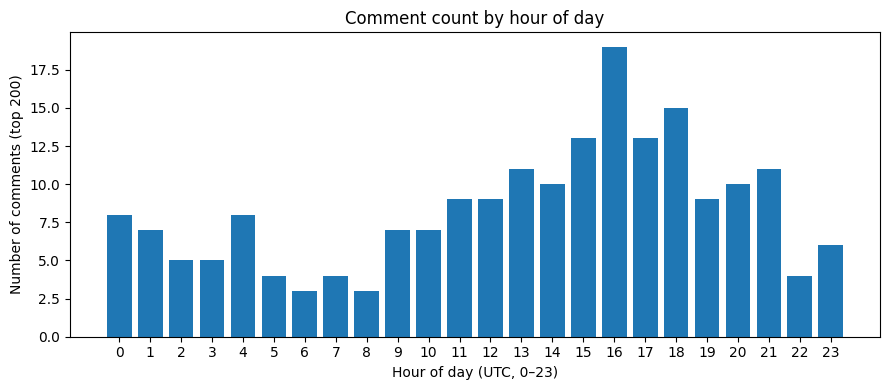

In [ ]:
# Parse hour (0–23) from each timestamp
hours = []
for c in selected_comments:
    try:
        dt = datetime.fromisoformat(c['timestamp'].replace('Z', '+00:00'))  # UTC
        hours.append(dt.hour)
    except Exception:
        pass  # skip bad timestamps

# Count
hour_counts = Counter(hours)
xs = list(range(24))
ys = [hour_counts.get(h, 0) for h in xs]

plt.figure(figsize=(9,4))
plt.bar(xs, ys)
plt.xticks(xs)
plt.xlabel("Hour of day (UTC, 0–23)")
plt.ylabel("Number of comments (top 200)")
plt.title("Comment count by hour of day")
plt.tight_layout()
plt.savefig('comment_count_per_hour.png')
plt.show()


The bar plot displays number of comments posted per hour using UTC as the global time reference. Although there us and downs in the comment activity throughout the day, the peak is observed at between 16:00 and 18:00 UTC. This likely corresponds to their afternoon or evening hours depending on viewer’s location. It highlights the times when people are generally more active online.

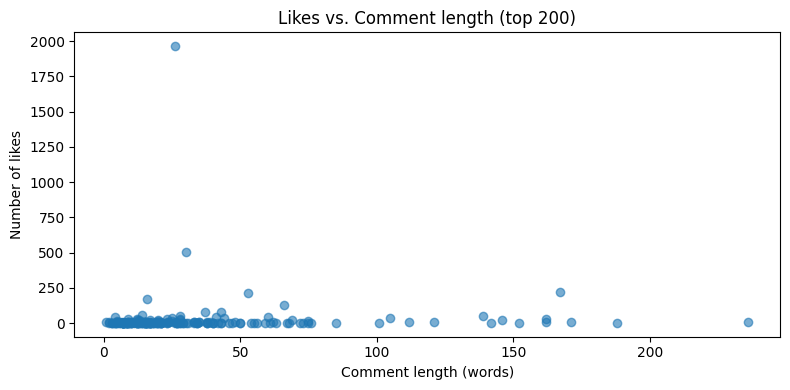

In [ ]:
# Scatter plot of comment length vs. like count
comment_lengths_api = []
likes_api = []
for c in selected_comments:
    comment_lengths_api.append(len(c['clean_text'].split()))
    likes_api.append(c['like_count'])

if likes_api:
    plt.figure(figsize=(8, 4))
    plt.scatter(comment_lengths_api, likes_api, alpha=0.6)
    plt.xlabel('Comment length (words)')
    plt.ylabel('Number of likes')
    plt.title('Likes vs. Comment length (top 200)')
    plt.tight_layout()
    plt.savefig('comment_length_vs_likes.png')
    plt.show()
else:
    print('No like count data available for comments.')

In the scatter plot above, most of the comments are short, which only a few likes around 1- 60. However, a handful of long comments attract high like counts such as170, 220, 505 including having an outlier Comment having nearly 2000 likes. Overall, there is no strong relationship between length and likes.